In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from astropy import units as u
from astropy import time
from astropy.coordinates import representation

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.plotting.static import StaticOrbitPlotter

import emcee
import corner
import timeit

In [2]:
R_earth = 6378.1
v_c = 300000

# Real orbital elements for International Space Station
# Data from ISS at 2019-apr-10

a    = (R_earth + 409) * u.km
ecc  =   0.0001586 * u.one
inc  =  51.6418    * u.deg
raan = 332.5814    * u.deg
argp = 179.7333    * u.deg
nu   =-179.6181    * u.deg

# Arbitrary Value, (few hours of diference to true data.)
EPOCH = time.Time('2019-04-10 12:00:00.0' , format='iso')


# Generate the orbit object "iss"
iss = Orbit.from_classical(Earth, a=a, ecc=ecc, inc=inc, raan=raan, argp=argp, nu=nu, epoch=EPOCH)

In [3]:
iss.epoch.unix

1554897600.0

In [4]:
# ISS classical orbital elements.
iss.classical()

(<Quantity 6787.1 km>,
 <Quantity 0.0001586>,
 <Quantity 51.6418 deg>,
 <Quantity 332.5814 deg>,
 <Quantity 179.7333 deg>,
 <Quantity -179.6181 deg>)

| symbol | description |
|:--------:|------|
|   a | semi-major axis| 
| ecc | eccentricity|
| inc | inclination|
|raan | right ascension of the ascending node|
|argp | argument of the pericenter|
|  nu | true anomaly|

In [5]:


deltaT = 10 * u.second

iss_propagation = []
iss_r = []
iss_v = []
iss_t = []


for i in range(20):
    aux = iss.propagate(deltaT * i)
    iss_propagation.append(aux)
    
    iss_r.append(aux.r )
    iss_v.append(aux.v )
    iss_t.append(aux.epoch.unix)


In [6]:
a = np.array([6206.87748242, -2681.198044  ,   604.2233833])
a /= np.linalg.norm(a)
a = a * R_earth


b = np.array([6250.0, -2700.0, 500.0])
b /= np.linalg.norm(b)
b = b * R_earth


c = np.array([6100.0, -2800.0, 500.0])
c /= np.linalg.norm(c)
c = c * R_earth

d = np.array([5800.0, -2500.0, 200.0])
d /= np.linalg.norm(d)
d = d * R_earth


BaseA = a
BaseB = b
BaseC = c
BaseD = d

In [7]:
iss_r = np.array(iss_r)
iss_v = np.array(iss_v)

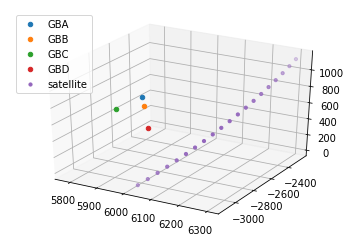

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(BaseA[0], BaseA[1], BaseA[2], label="GBA")
ax.scatter(BaseB[0], BaseB[1], BaseB[2], label="GBB")
ax.scatter(BaseC[0], BaseC[1], BaseC[2], label="GBC")
ax.scatter(BaseD[0], BaseD[1], BaseD[2], label="GBD")
ax.scatter(iss_r[:,0], iss_r[:,1], iss_r[:,2], s=10, label="satellite")
ax.legend(loc=0)
plt.show()

In [9]:
iss.represent_as(representation.SphericalRepresentation)

<SphericalRepresentation (lon, lat, distance) in (rad, rad, km)
    (5.8058882, 0.00157662, 6788.17641014)
 (has differentials w.r.t.: 's')>

# Modeling data from true orbit

In [10]:
print(a,b,c,d)

[ 5831.92402699 -2519.22860379   567.7226394 ] [ 5839.37994399 -2522.6121358    467.15039552] [ 5780.58854732 -2653.38490697   473.81873339] [ 5854.22840474 -2523.37431239   201.86994499]


In [11]:
bases=[a,b,c,d]
for base in bases:
    print(base, np.linalg.norm(base))

[ 5831.92402699 -2519.22860379   567.7226394 ] 6378.1
[ 5839.37994399 -2522.6121358    467.15039552] 6378.1
[ 5780.58854732 -2653.38490697   473.81873339] 6378.1
[ 5854.22840474 -2523.37431239   201.86994499] 6378.099999999999


In [12]:
def distance(a, b):
    x0 = a[0]
    x1 = a[1]
    x2 = a[2]
    
    y0 = b[0]
    y1 = b[1]
    y2 = b[2]
    
    dist = (x0-y0)**2 + (x1-y1)**2 + (x2-y2)**2
    dist = dist**0.5
    return dist

In [13]:
distance(a,b)

100.90498117499068

In [14]:
distance(b,c)

143.53540584097703

In [15]:
distance(c,d)

310.29296932655024

In [16]:
distance(a,c)

171.61348641476735

In [17]:
distance(a,d)

366.5554066865012

In [18]:
iss_r[0]

array([ 6029.52111627, -3118.34884883,    10.70236677])

In [19]:
distance(d,iss_r[0])

649.0510586144488

In [20]:
iss_v[0]


array([2.17594474, 4.22796288, 6.00833534])

In [21]:
def rel_vel_to_base(r, v, Base):
        """
        Returns the relative speed of the satellite to
        some ground location. This velocity is 
        positive if the satellite is going towards
        the ground location, negative if is going 
        outwards.
        """
        
        x1 = Base[0]
        y1 = Base[1]
        z1 = Base[2]
    
        x_r = r[0] - x1
        y_r = r[1] - y1
        z_r = r[2] - z1  

        d = ( x_r ** 2 + y_r ** 2 + z_r ** 2 )**0.5
    
        ux  = x_r / d
        uy  = y_r / d
        uz  = z_r / d
    
        u = np.array([ux, uy, uz])
        
        return np.inner(-u,v)

In [22]:
Real_Data = []
A=[]
B=[]
C=[]
D=[]
T = []

for t in range(len(iss_t)):
    A.append(rel_vel_to_base( iss_r[t], iss_v[t], BaseA) )
    B.append(rel_vel_to_base( iss_r[t], iss_v[t], BaseB) )
    C.append(rel_vel_to_base( iss_r[t], iss_v[t], BaseC) )
    D.append(rel_vel_to_base( iss_r[t], iss_v[t], BaseD) )
    T.append(t*deltaT.value)

In [23]:
A = np.array(A)
B = np.array(B)
C = np.array(C)
D = np.array(D)

T = np.array(T)

This is the measured signal by Ground Bases.

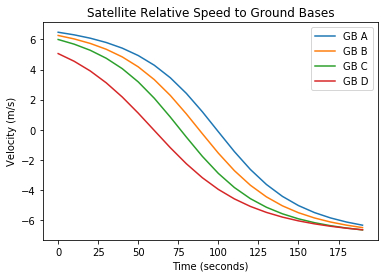

In [24]:
fig = plt.figure()

plt.title("Satellite Relative Speed to Ground Bases")

plt.plot(T, A, label="GB A")
plt.plot(T, B, label="GB B")
plt.plot(T, C, label="GB C")
plt.plot(T, D, label="GB D")

plt.xlabel("Time (seconds)")
plt.ylabel("Velocity (m/s)")
plt.legend(loc=0)

plt.show()

# Monte Carlo

In [25]:
def log_likelihood_PLOTS(param):
    """
    param = [a, ecc, inc, raan, argp, nu = param]
    """
    a, ecc, inc, raan, argp, nu = param

    ### Limit the parameter space ###
    
    if a < R_earth + 100:
        return -numpy.inf
    
    if ecc < 0:
        return -numpy.inf
    
    if abs(inc)> 90:
        return -numpy.inf
    
    a    =   a  * u.km
    ecc  = ecc  * u.one
    inc  = inc  * u.degree
    raan = raan * u.deg
    argp = argp * u.deg
    nu   = nu   * u.deg
    
    MCsat = Orbit.from_classical(Earth, a=a, ecc=ecc, inc=inc, raan=raan, argp=argp, nu=nu, epoch=EPOCH)
    
    MCsat.classical()
    
    MCsat_r      = []
    MCsat_v      = []
    MCsat_t      = []
    
    MCsatV_rel_A = []
    MCsatV_rel_B = []
    MCsatV_rel_C = []
    MCsatV_rel_D = []
    
    for i in range(20):
        aux = MCsat.propagate(deltaT * i)
        MCsat_r.append(aux.r )
        MCsat_v.append(aux.v )
        MCsat_t.append(aux.epoch.unix)
        
    MCsat_r = np.array(MCsat_r)
    MCsat_v = np.array(MCsat_v)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(BaseA[0], BaseA[1], BaseA[2], label="GBA")
    ax.scatter(BaseB[0], BaseB[1], BaseB[2], label="GBB")
    ax.scatter(BaseC[0], BaseC[1], BaseC[2], label="GBC")
    ax.scatter(BaseD[0], BaseD[1], BaseD[2], label="GBD")
    ax.scatter(iss_r[:,0], iss_r[:,1], iss_r[:,2], s=10, label="Real Orbit")
    ax.scatter(MCsat_r[:,0], MCsat_r[:,1], MCsat_r[:,2], s=10, label="MC sim Orbit")
    ax.legend(loc=0)
    plt.show()
    
    
    MCsat_A=[]
    MCsat_B=[]
    MCsat_C=[]
    MCsat_D=[]

    for t in range(len(iss_t)):
        MCsat_A.append(rel_vel_to_base( MCsat_r[t], MCsat_v[t], BaseA) )
        MCsat_B.append(rel_vel_to_base( MCsat_r[t], MCsat_v[t], BaseB) )
        MCsat_C.append(rel_vel_to_base( MCsat_r[t], MCsat_v[t], BaseC) )
        MCsat_D.append(rel_vel_to_base( MCsat_r[t], MCsat_v[t], BaseD) )

    MCsat_A = np.array(MCsat_A)
    MCsat_B = np.array(MCsat_B)
    MCsat_C = np.array(MCsat_C)
    MCsat_D = np.array(MCsat_D)

    fig = plt.figure()
    plt.title("MC-Satellite Relative Speed to Ground Bases")

    plt.plot(T, MCsat_A, label="MC sim A", c="b")
    plt.plot(T, MCsat_B, label="MC sim B", c="orange")
    plt.plot(T, MCsat_C, label="MC sim C", c="green")
    plt.plot(T, MCsat_D, label="MC sim D", c="r")

    plt.scatter(T, A, label="Measured by A", c="b")    
    plt.scatter(T, B, label="Measured by B", c="orange")
    plt.scatter(T, C, label="Measured by C", c="green")    
    plt.scatter(T, D, label="Measured by D", c="r")

    plt.xlabel("Time (seconds)")
    plt.ylabel("Velocity (m/s)")
    plt.legend(loc=0)
    plt.show()

    
    chi2 = 0
    sigma = np.log(2*np.pi)
    for t in range(len(T)):
        chi2 += (MCsat_A[i]-A[i])**2 + sigma
        chi2 += (MCsat_B[i]-B[i])**2 + sigma
        chi2 += (MCsat_C[i]-C[i])**2 + sigma
        chi2 += (MCsat_D[i]-D[i])**2 + sigma
    print("Log Likelihood: ", chi2)
    return chi2

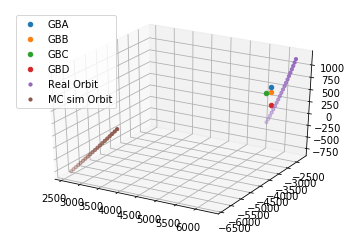

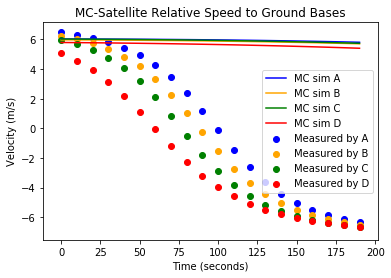

Log Likelihood:  12053.819621671408


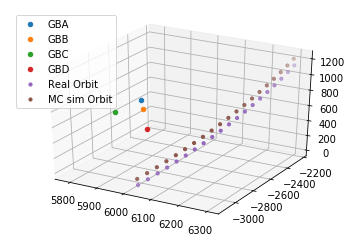

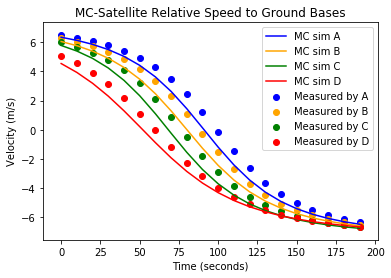

Log Likelihood:  147.64013649182104


147.64013649182104

In [26]:
param = [R_earth+500, 0.0012, 40, 300, 160, -170 ]

log_likelihood_PLOTS(param)

param = [R_earth+409, 0.00015, 51, 332, 180, -179 ]

log_likelihood_PLOTS(param)


In [27]:
iss.classical()

(<Quantity 6787.1 km>,
 <Quantity 0.0001586>,
 <Quantity 51.6418 deg>,
 <Quantity 332.5814 deg>,
 <Quantity 179.7333 deg>,
 <Quantity -179.6181 deg>)

In [77]:
def log_likelihood(param):
    """
    param = [a, ecc, inc, raan, argp, nu]
    """
    a, ecc, inc, raan, argp, nu = param

    ### Limit the parameter space ###
    
    if a < R_earth + 100:
        return -numpy.inf
    
    if (ecc < 0) or (ecc > 1) :
        return -numpy.inf
    
    if (inc < 0) or (inc > 180):
        return -numpy.inf
    
    if abs(raan) > 360:
        return -numpy.inf
    
    if abs(nu) > 180:
        return -numpy.inf
    
    a    =   a  * u.km
    ecc  = ecc  * u.one
    inc  = inc  * u.degree
    raan = raan * u.deg
    argp = argp * u.deg
    nu   = nu   * u.deg
    
    MCsat = Orbit.from_classical(Earth, a=a, ecc=ecc, inc=inc, raan=raan, argp=argp, nu=nu, epoch=EPOCH)
    
    MCsat.classical()
    
    MCsat_r      = []
    MCsat_v      = []
    MCsat_t      = []
    
    MCsatV_rel_A = []
    MCsatV_rel_B = []
    MCsatV_rel_C = []
    MCsatV_rel_D = []
    
    for i in range(20):
        aux = MCsat.propagate(deltaT * i)
        MCsat_r.append(aux.r )
        MCsat_v.append(aux.v )
        MCsat_t.append(aux.epoch.unix)
        
    MCsat_r = np.array(MCsat_r)
    MCsat_v = np.array(MCsat_v)
    
    MCsat_A=[]
    MCsat_B=[]
    MCsat_C=[]
    MCsat_D=[]

    for t in range(len(iss_t)):
        MCsat_A.append(rel_vel_to_base( MCsat_r[t], MCsat_v[t], BaseA) )
        MCsat_B.append(rel_vel_to_base( MCsat_r[t], MCsat_v[t], BaseB) )
        MCsat_C.append(rel_vel_to_base( MCsat_r[t], MCsat_v[t], BaseC) )
        MCsat_D.append(rel_vel_to_base( MCsat_r[t], MCsat_v[t], BaseD) )

    MCsat_A = np.array(MCsat_A)
    MCsat_B = np.array(MCsat_B)
    MCsat_C = np.array(MCsat_C)
    MCsat_D = np.array(MCsat_D)

    
    chi2 = 0
    sigma = np.log(2*np.pi)
    for t in range(len(T)):
        chi2 += (MCsat_A[i]-A[i])**2 + sigma
        chi2 += (MCsat_B[i]-B[i])**2 + sigma
        chi2 += (MCsat_C[i]-C[i])**2 + sigma
        chi2 += (MCsat_D[i]-D[i])**2 + sigma
    #print("Log Likelihood: ", chi2)
    return chi2

In [31]:
MCMC_steps = 50

nwalkers, ndim = 40, 6
p0 = np.zeros((nwalkers,ndim))

# param = [R_earth+409, 0.00015, 51, 332, 180, -179 ]

theta = [R_earth + 500, 0.001, 0, 0, 0, 0]

for i in range(nwalkers):
    p0[i,0] = theta[0] * np.random.normal(1, 0.2)
    p0[i,1] = theta[1] + 0.1 * np.random.rand()
    p0[i,2] = theta[2] * np.random.normal(0, 30)
    p0[i,3] = theta[3] + 360 * np.random.rand()
    p0[i,4] = theta[4] + 360 * np.random.rand()
    p0[i,5] = theta[5] + 360 * np.random.rand()

In [32]:
import numpy

toc = timeit.default_timer()

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
pos, prob, state = sampler.run_mcmc(p0, MCMC_steps)

tic = timeit.default_timer()
print("Time elapsed: ", tic -toc, "seconds")

/home/filipo/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning:

invalid value encountered in subtract

/home/filipo/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning:

invalid value encountered in greater



Time elapsed:  188.8375078459976 seconds


In [34]:
samples = sampler.chain[:,0:,:].reshape((-1, ndim))


In [35]:
fig = corner.corner(samples, labels=["a", "ecc", "inc", "raan", "argp", "nu"])

ValueError: It looks like the parameter(s) in column(s) 2 have no dynamic range. Please provide a `range` argument.

In [36]:
samples2 = np.delete(samples, 2, axis=1)

In [37]:
samples2.shape

(2000, 5)

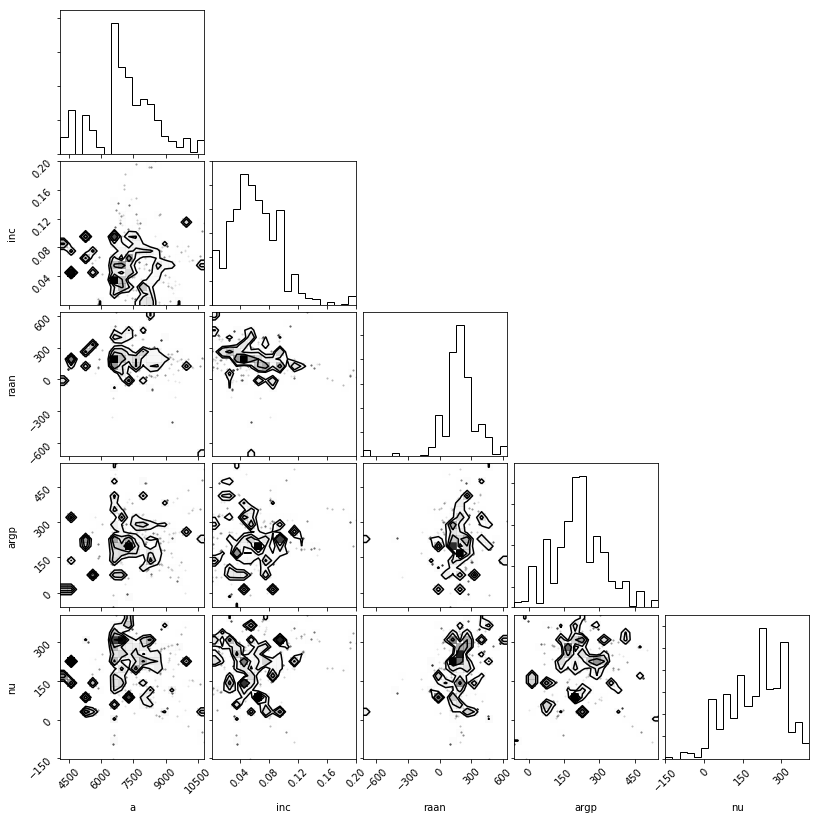

In [38]:
fig = corner.corner(samples2, labels=["a", "inc", "raan", "argp", "nu"])

In [43]:
MCMC_steps = 50

nwalkers, ndim = 40, 6
p2 = np.zeros((nwalkers,ndim))

# param = [R_earth+409, 0.00015, 51, 332, 180, -179 ]

theta = [R_earth + 410, 0.0015, 51, 332, 180, -179]

for i in range(nwalkers):
    p2[i,0] = theta[0] + np.random.normal(0, 10)
    p2[i,1] = theta[1] + 0.2 * np.random.rand()
    p2[i,2] = theta[2] + np.random.normal(0, 10)
    p2[i,3] = theta[3] + np.random.normal(0, 10)
    p2[i,4] = theta[4] + 360 * np.random.normal(0, 10)
    p2[i,5] = theta[5] + 360 * np.random.normal(0, 10)

In [44]:
import numpy

toc = timeit.default_timer()

sampler2 = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
pos2, prob2, state2 = sampler2.run_mcmc(p2, MCMC_steps, progress=True)

tic = timeit.default_timer()
print("Time elapsed: ", tic -toc, "seconds")

Time elapsed:  243.4629093609983 seconds


In [45]:
samples2 = sampler.chain[:,0:,:].reshape((-1, ndim))

In [47]:
fig = corner.corner(samples, labels=["a", "ecc", "inc", "raan", "argp", "nu"])

ValueError: It looks like the parameter(s) in column(s) 2 have no dynamic range. Please provide a `range` argument.

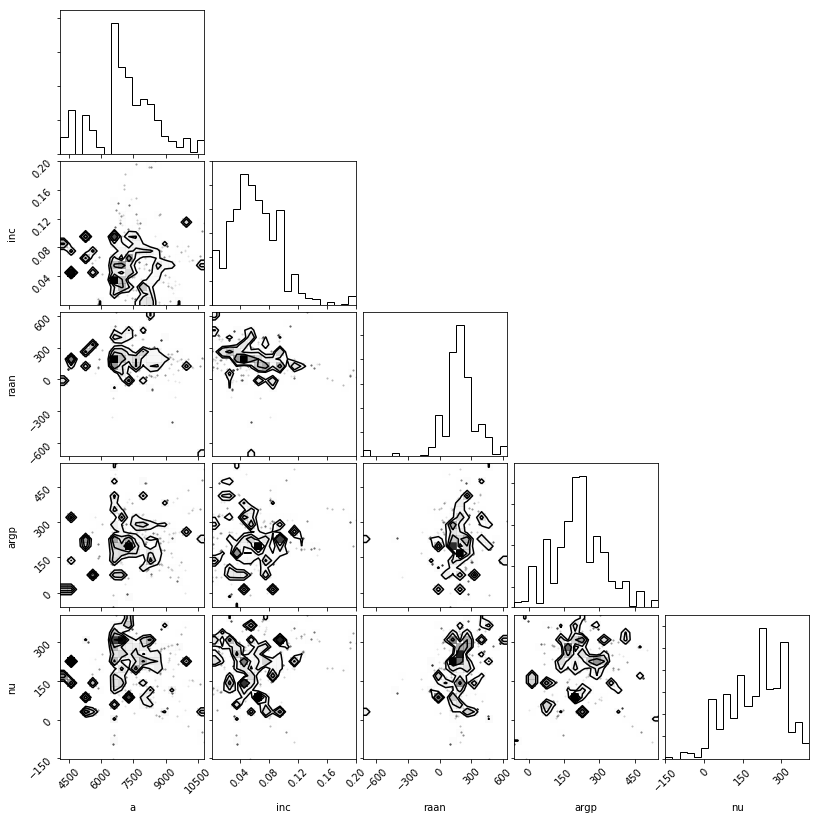

In [48]:
samples2b = np.delete(samples2, 2, axis=1)
fig = corner.corner(samples2b,labels=["a", "inc", "raan", "argp", "nu"])

In [49]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [50]:
print(emcee.__version__)


2.2.1


In [55]:
from multiprocessing import Pool
from multiprocessing import cpu_count

ncpu = cpu_count()
print("{} CPUs".format(ncpu))

4 CPUs


In [56]:
with Pool() as pool:
    
    sampler3 = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood)
    toc = timeit.default_timer()

    sampler3.run_mcmc(p2, MCMC_steps)

    tic = timeit.default_timer()
    print("Time elapsed: ", tic -toc, "seconds")

Time elapsed:  255.00575737799954 seconds


In [58]:

with Pool(4) as pool:
    
    sampler3 = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, threads=4)
    toc = timeit.default_timer()

    sampler3.run_mcmc(p2, 200)

    tic = timeit.default_timer()
    print("Time elapsed: ", tic -toc, "seconds")

Time elapsed:  150.74548150400005 seconds


In [60]:
sampler3.acceptance_fraction

array([0.04, 0.1 , 0.04, 0.08, 0.06, 0.04, 0.08, 0.08, 0.06, 0.12, 0.04,
       0.14, 0.16, 0.12, 0.06, 0.12, 0.06, 0.12, 0.06, 0.06, 0.08, 0.04,
       0.1 , 0.  , 0.08, 0.04, 0.  , 0.08, 0.04, 0.12, 0.08, 0.02, 0.1 ,
       0.04, 0.04, 0.1 , 0.02, 0.08, 0.08, 0.06])

In [63]:
sampler3.naccepted

array([2., 5., 2., 4., 3., 2., 4., 4., 3., 6., 2., 7., 8., 6., 3., 6., 3.,
       6., 3., 3., 4., 2., 5., 0., 4., 2., 0., 4., 2., 6., 4., 1., 5., 2.,
       2., 5., 1., 4., 4., 3.])

In [79]:
MCMC_steps = 50

nwalkers, ndim = 150, 6
p2 = np.zeros((nwalkers,ndim))

# param = [R_earth+409, 0.00015, 51, 332, 180, -179 ]

theta = [R_earth + 410, 0.0015, 51, 332, 180, -179]

for i in range(nwalkers):
    p2[i,0] = theta[0] + np.random.normal(0, 10)
    p2[i,1] = theta[1] + 0.2 * np.random.rand()
    p2[i,2] = theta[2] + np.random.normal(0, 5)
    p2[i,3] = theta[3] + np.random.normal(0, 5)
    p2[i,4] = theta[4] + np.random.normal(0, 5)
    p2[i,5] = theta[5] + np.random.normal(0, 5)
    
with Pool(4) as pool:
    
    sampler4 = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, threads=4)
    toc = timeit.default_timer()

    sampler4.run_mcmc(p2, MCMC_steps)

    tic = timeit.default_timer()
    print("Time elapsed: ", tic -toc, "seconds")

/home/filipo/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:335: RuntimeWarning:

invalid value encountered in subtract

/home/filipo/anaconda3/lib/python3.6/site-packages/emcee/ensemble.py:336: RuntimeWarning:

invalid value encountered in greater



Time elapsed:  386.3152548379985 seconds


In [65]:
sampler4.acceptance_fraction

array([0.05, 0.01, 0.04, 0.05, 0.07, 0.03, 0.05, 0.08, 0.08, 0.04, 0.07,
       0.03, 0.06, 0.09, 0.11, 0.04, 0.06, 0.06, 0.05, 0.04, 0.01, 0.02,
       0.05, 0.05, 0.04, 0.05, 0.02, 0.08, 0.06, 0.08, 0.04, 0.04, 0.05,
       0.02, 0.05, 0.04, 0.04, 0.04, 0.04, 0.04, 0.07, 0.01, 0.06, 0.04,
       0.05, 0.05, 0.02, 0.07, 0.03, 0.02, 0.07, 0.05, 0.06, 0.07, 0.06,
       0.09, 0.05, 0.03, 0.04, 0.05, 0.07, 0.06, 0.06, 0.07, 0.06, 0.04,
       0.03, 0.03, 0.05, 0.04, 0.04, 0.03, 0.08, 0.02, 0.04, 0.03, 0.06,
       0.03, 0.05, 0.05])

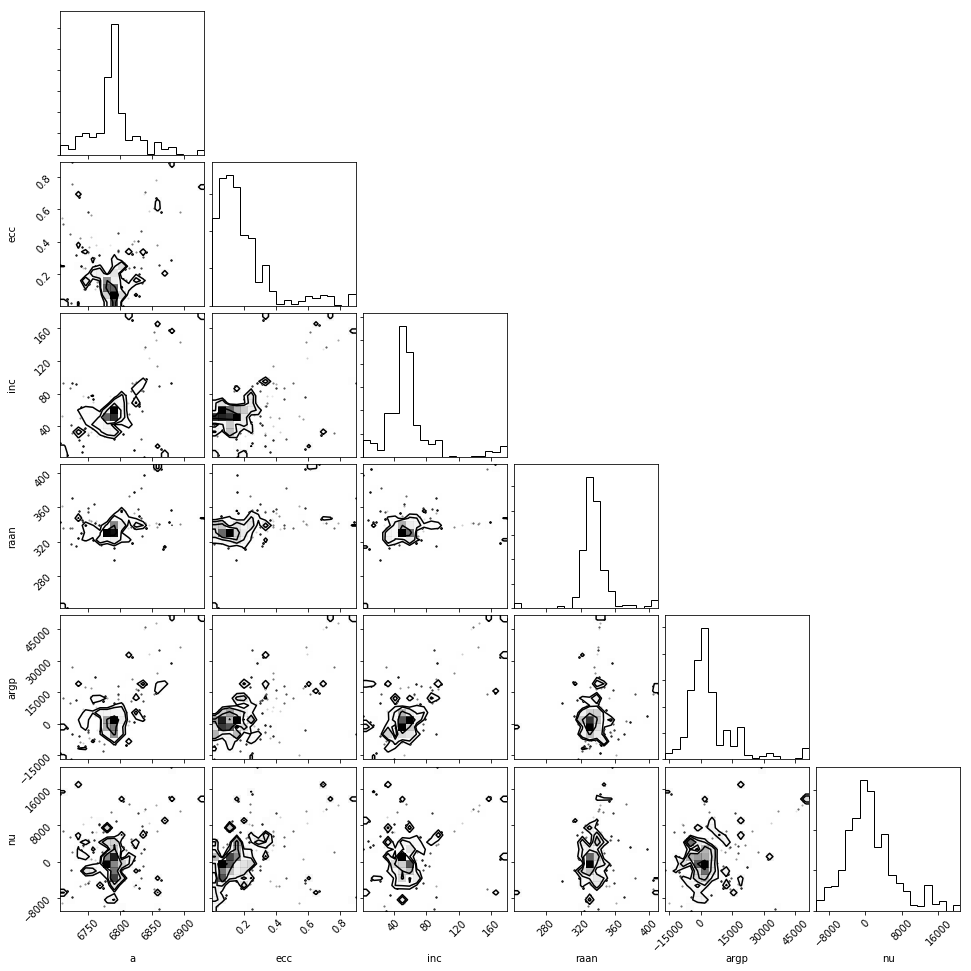

In [76]:
samples4 = sampler4.chain[:,50:,:].reshape((-1, ndim))
fig      = corner.corner(samples4, labels=["a", "ecc", "inc", "raan", "argp", "nu"])

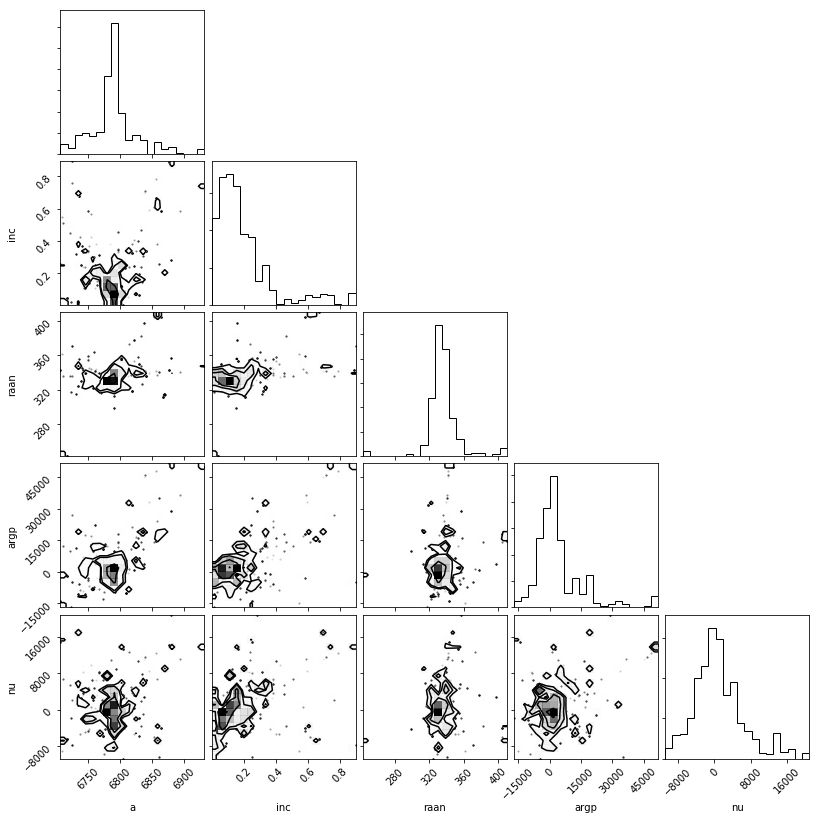

In [75]:
samples4b = np.delete(samples4, 2, axis=1)
fig       = corner.corner(samples4b,labels=["a", "inc", "raan", "argp", "nu"])